In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def filter_population_for_new_york(dataframe):
    ny_population_data = dataframe[dataframe['Description'] == 'New York']
    
    filtered_population_data = ny_population_data.drop(columns=['IBRC_Geo_ID', 'Statefips', 'Countyfips'], errors='ignore')

    filtered_population_data = filtered_population_data[(filtered_population_data['Year'] >= 2012) & (filtered_population_data['Year'] <= 2019)]
    return filtered_population_data

def filter_and_aggregate_traffic_data(dataframe):
    traffic_data = dataframe.drop(columns=['ID', 'SegmentID', 'From', 'To', 'Direction'], errors='ignore')
    traffic_data_cleaned = traffic_data.dropna().copy()

    traffic_data_cleaned.columns = [
        col.strip().replace(" ", "_").replace("-", "_").replace(":", "").replace("/", "").lower() for col in traffic_data_cleaned.columns
    ]

    interval_mapping = {
        '1200_100_am': '1200_400_am',
        '100_200am': '1200_400_am',
        '200_300am': '1200_400_am',
        '300_400am': '1200_400_am',
        '400_500am': '400_800_am',
        '500_600am': '400_800_am',
        '600_700am': '400_800_am',
        '700_800am': '400_800_am',
        '800_900am': '800_1200_pm',
        '900_1000am': '800_1200_pm',
        '1000_1100am': '800_1200_pm',
        '1100_1200pm': '800_1200_pm',
        '1200_100pm': '1200_400_pm',
        '100_200pm': '1200_400_pm',
        '200_300pm': '1200_400_pm',
        '300_400pm': '1200_400_pm',
        '400_500pm': '400_800_pm',
        '500_600pm': '400_800_pm',
        '600_700pm': '400_800_pm',
        '700_800pm': '400_800_pm',
        '800_900pm': '800_1200_am',
        '900_1000pm': '800_1200_am',
        '1000_1100pm': '800_1200_am',
        '1100_1200am': '800_1200_am',
    }

    
    
    traffic_data_cleaned.fillna(0, inplace=True)

    traffic_data_cleaned['date'] = pd.to_datetime(traffic_data_cleaned['date'], errors='coerce')

    traffic_data_cleaned['year'] = traffic_data_cleaned['date'].dt.year

    aggregated_traffic_data = traffic_data_cleaned.groupby('year').sum(numeric_only=True)

    for new_interval in set(interval_mapping.values()):
        columns_to_aggregate = [col for col, interval in interval_mapping.items() if interval == new_interval and col in aggregated_traffic_data.columns]
        aggregated_traffic_data[new_interval] = aggregated_traffic_data[columns_to_aggregate].sum(axis=1)

    columns_to_drop = [col for col in interval_mapping.keys() if col in aggregated_traffic_data.columns]
    aggregated_traffic_data.drop(columns=columns_to_drop, inplace=True)

    return aggregated_traffic_data

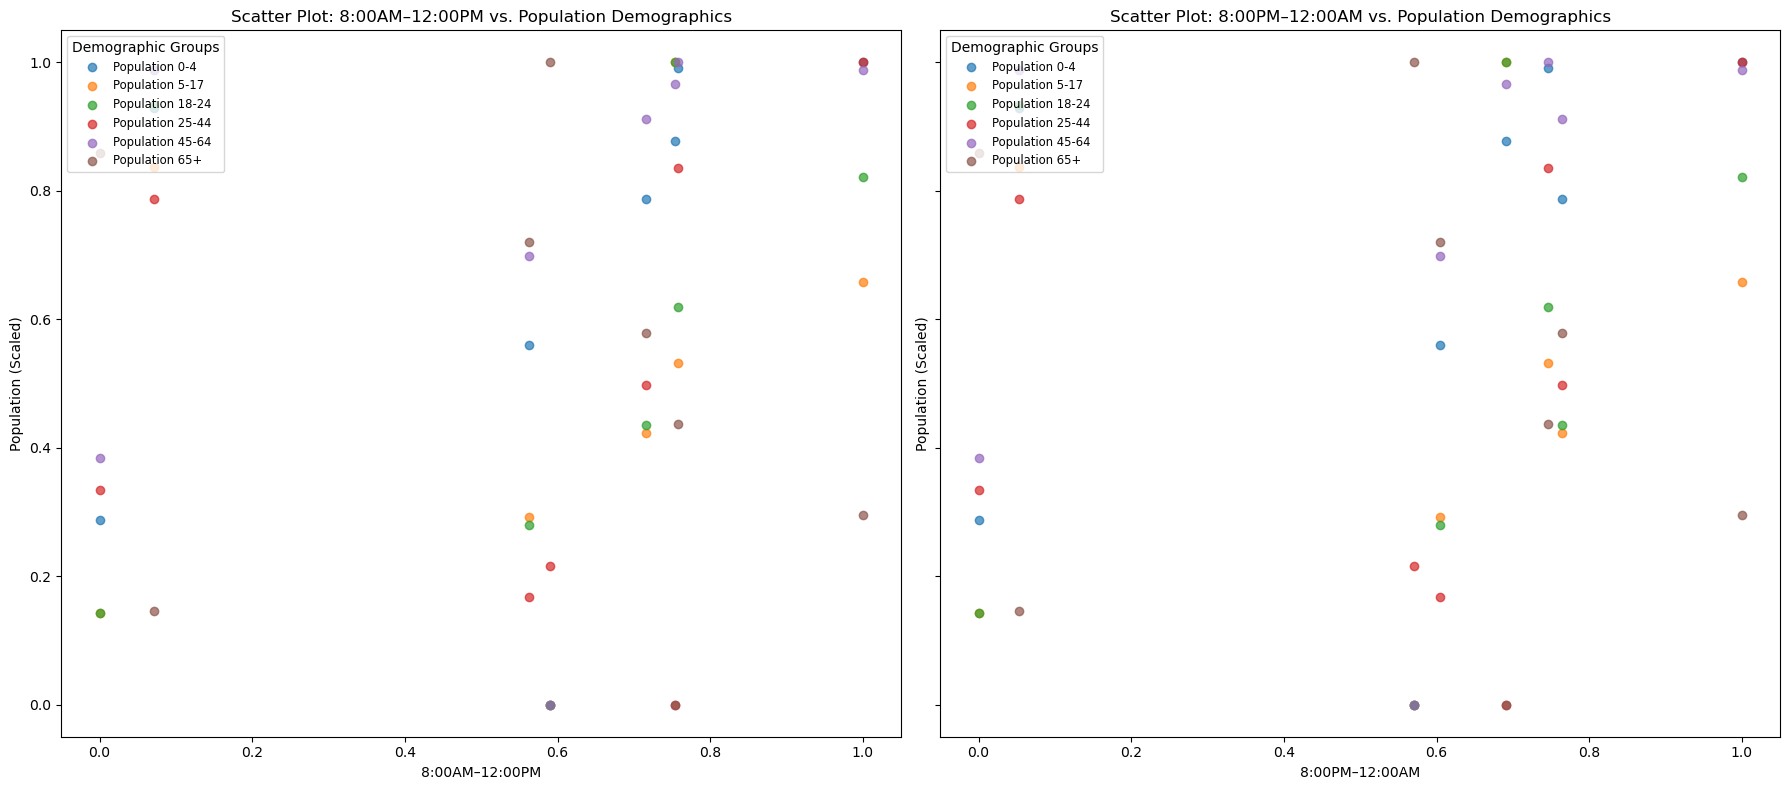

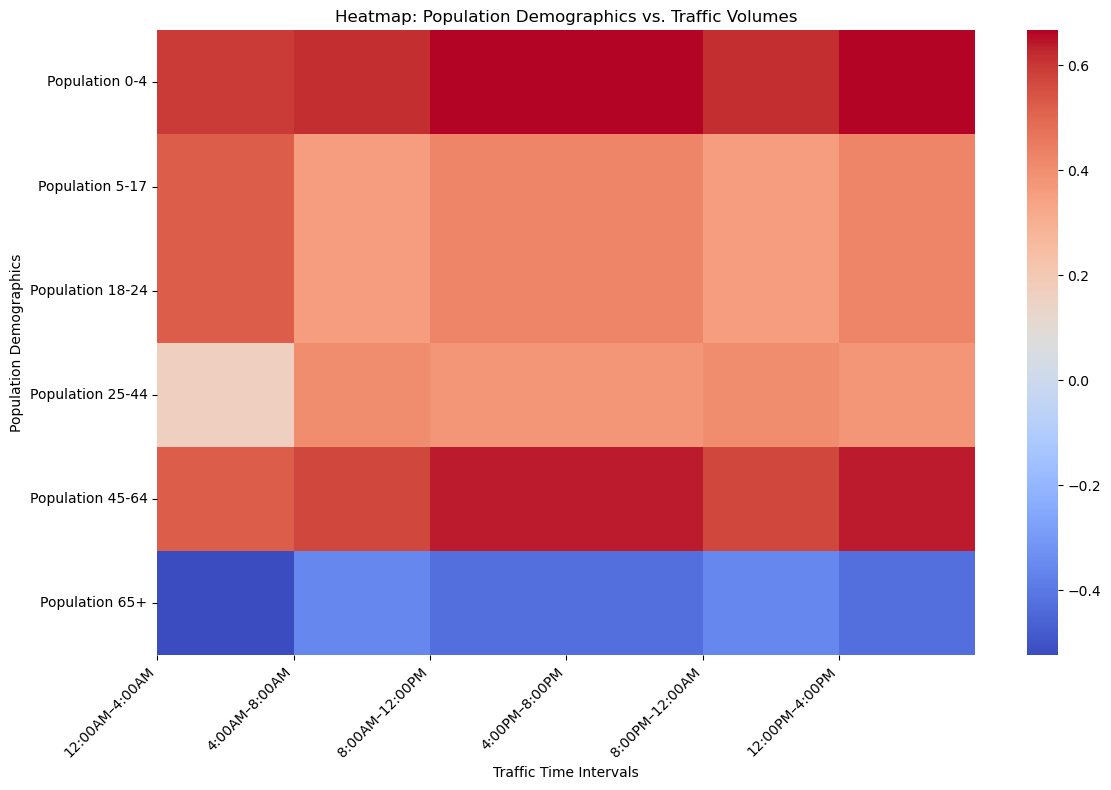

In [5]:
from sklearn.preprocessing import MinMaxScaler


def correlation_analysis(dataframe):
    demographic_columns = ['Population 0-4', 'Population 5-17', 'Population 18-24', 
                           'Population 25-44', 'Population 45-64', 'Population 65+']
    traffic_columns = ['1200_400_am', '400_800_am', '800_1200_pm', '400_800_pm', '800_1200_am', '1200_400_pm']

    numeric_columns = dataframe[demographic_columns + traffic_columns].select_dtypes(include=['float64', 'int64'])

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(numeric_columns)
    scaled_dataframe = pd.DataFrame(scaled_data, columns=numeric_columns.columns)

    fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)  

    for demo_col in demographic_columns:
        axes[0].scatter(scaled_dataframe[traffic_columns[2]], scaled_dataframe[demo_col], label=demo_col, alpha=0.7)
    axes[0].set_title('Scatter Plot: 8:00AM–12:00PM vs. Population Demographics')
    axes[0].set_xlabel('8:00AM–12:00PM')
    axes[0].set_ylabel('Population (Scaled)')
    axes[0].legend(title='Demographic Groups', loc='upper left', fontsize='small')

    for demo_col in demographic_columns:
        axes[1].scatter(scaled_dataframe[traffic_columns[4]], scaled_dataframe[demo_col], label=demo_col, alpha=0.7)
    axes[1].set_title('Scatter Plot: 8:00PM–12:00AM vs. Population Demographics')
    axes[1].set_xlabel('8:00PM–12:00AM')
    axes[1].set_ylabel('Population (Scaled)')  
    axes[1].legend(title='Demographic Groups', loc='upper left', fontsize='small')

    plt.tight_layout()
    plt.show()
    correlation_matrix = scaled_dataframe.corr(method='spearman')

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix.loc[demographic_columns, traffic_columns], annot=False, cmap='coolwarm', cbar=True)
    plt.title('Heatmap: Population Demographics vs. Traffic Volumes')
    plt.xlabel('Traffic Time Intervals')
    plt.ylabel('Population Demographics')
    custom_labels = ['12:00AM–4:00AM', '4:00AM–8:00AM', '8:00AM–12:00PM', 
                     '4:00PM–8:00PM', '8:00PM–12:00AM', '12:00PM–4:00PM']
    plt.xticks(ticks=range(len(traffic_columns)), labels=custom_labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return scaled_dataframe.corr(method='spearman')



def main():
    traffic_data = pd.read_csv("Traffic_Volume_Counts.csv") 
    population_data = pd.read_csv("Population_by_Age_and_Sex.csv")

    filtered_population_data = filter_population_for_new_york(population_data)
    aggregated_traffic_data = filter_and_aggregate_traffic_data(traffic_data)

    combined_data = pd.merge(filtered_population_data, aggregated_traffic_data, left_on='Year', right_on='year')


    correlation_matrix = correlation_analysis(combined_data)

if __name__ == "__main__":
    main()

Traffic Volume Decomposition:


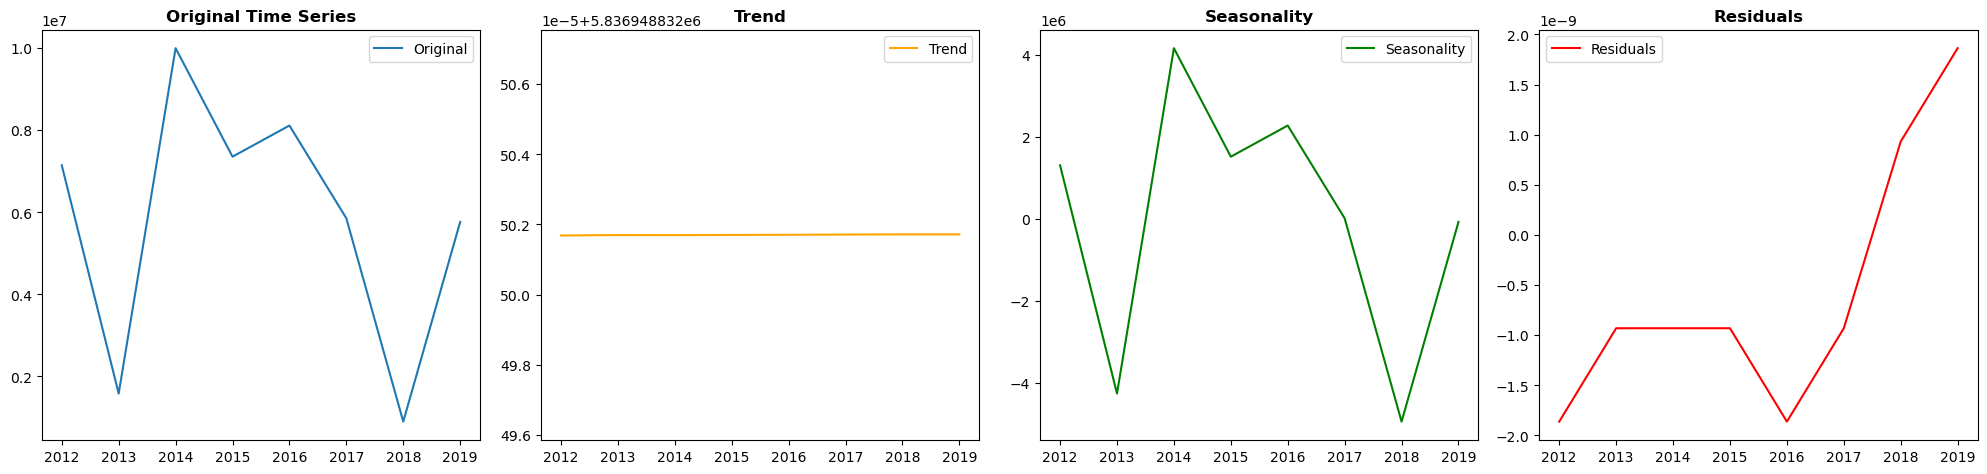

Population Decomposition:


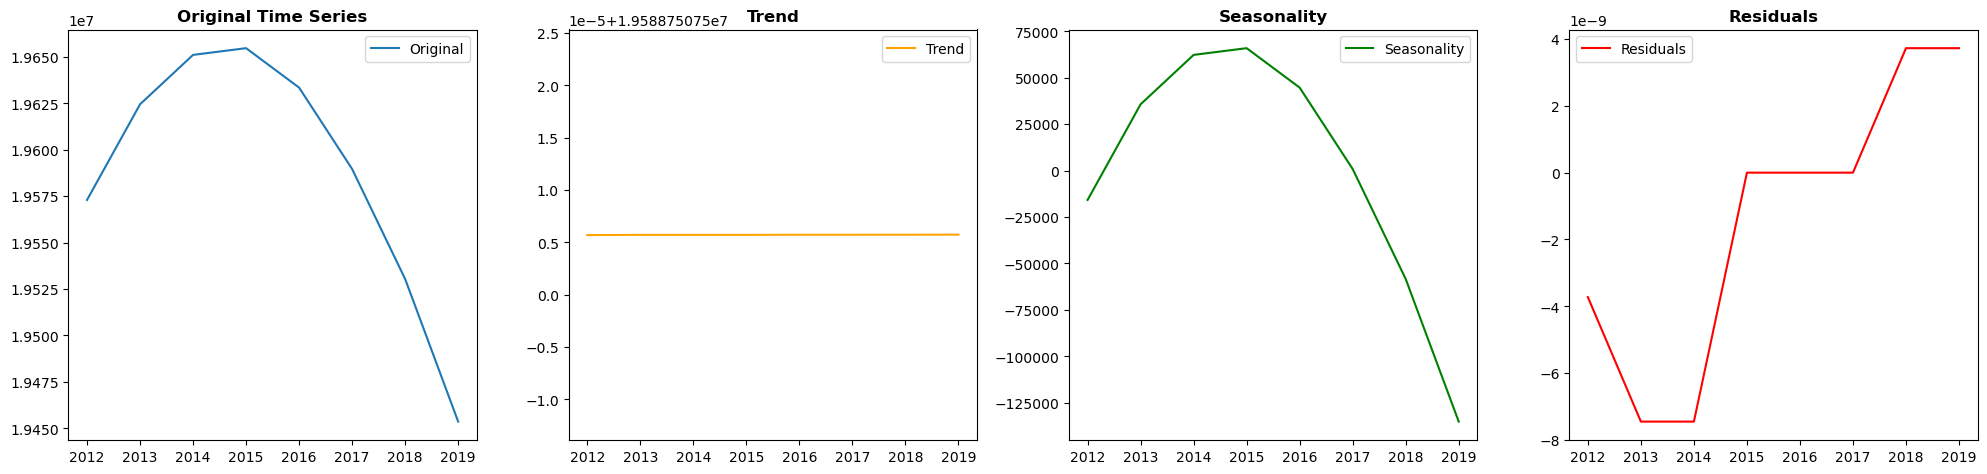

In [3]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

def time_series_decomposition(dataframe, column, period):
    dataframe = dataframe.set_index('Year')  # Set the year as the index
    series = dataframe[column]
    
    stl = STL(series, period=period, robust=True)
    result = stl.fit()
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=False)  # 1 row, 4 columns
    
    axes[0].plot(series, label='Original')
    axes[0].set_title('Original Time Series', fontweight='bold')
    axes[0].legend()
    
    axes[1].plot(result.trend, label='Trend', color='orange')
    axes[1].set_title('Trend', fontweight='bold')
    axes[1].legend()
    
    axes[2].plot(result.seasonal, label='Seasonality', color='green')
    axes[2].set_title('Seasonality', fontweight='bold')
    axes[2].legend()
    
    axes[3].plot(result.resid, label='Residuals', color='red')
    axes[3].set_title('Residuals', fontweight='bold')
    axes[3].legend()
    plt.tight_layout()
    plt.show()

def main():
    traffic_data = pd.read_csv("Traffic_Volume_Counts.csv") 
    population_data = pd.read_csv("Population_by_Age_and_Sex.csv")
    
    filtered_population_data = filter_population_for_new_york(population_data)
    aggregated_traffic_data = filter_and_aggregate_traffic_data(traffic_data)
    
    combined_data = pd.merge(filtered_population_data, aggregated_traffic_data, left_on='Year', right_on='year')
    
    print("Traffic Volume Decomposition:")
    time_series_decomposition(combined_data, column='400_800_am', period=12)  
    
    print("Population Decomposition:")
    time_series_decomposition(combined_data, column='Total Population', period=12)  

if __name__ == "__main__":
    main()